#### Goal: Simulate arcs

In [ ]:
import autofit as af
import autolens as al
import autolens.plot as aplt

import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_7/Simulation_Data/"

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [ ]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)             #DM component

In [3]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

The grid used to simulate the image. 

For simulating an image of a strong lens, we recommend using a GridIterate object. This represents a grid of (y,x) 
coordinates like an ordinary Grid, but when the light-profile's image is evaluated below (using the Tracer) the 
sub-size of the grid is iteratively increased (in steps of 2) until the input fractional accuracy of 
99.99% is met.

This ensures that the divergent and bright central regions of the source galaxy are fully resolved when determining the
total flux emitted within a pixel.

In [4]:
grid = al.GridIterate.uniform(
    shape_2d=(100, 100),
    pixel_scales=0.1,
    fractional_accuracy=0.9999,
    sub_steps=[2],
)

In [5]:
"""Simulate a simple Gaussian PSF for the image."""
psf = al.Kernel.from_gaussian(
    shape_2d=(11, 11), sigma=0.1, pixel_scales=grid.pixel_scales
)

In [6]:
"""
To simulate the imaging dataset we first create a simulator, which defines the expoosure time, background sky,
noise levels and psf of the dataset that is simulated.
"""
simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=True,
)


Setup the lens galaxy's mass (MGE+DM+SHEAR) and source galaxy light (elliptical Sersic) for this simulated lens.


In [7]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()


#Components

mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =kappa_ * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)


#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

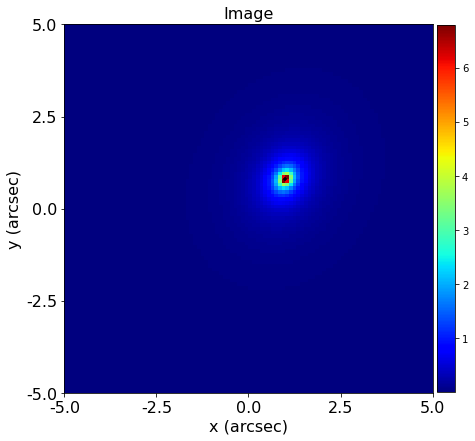

In [16]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    light=al.lp.EllipticalSersic(
        centre=(0.8, 1.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)
aplt.Galaxy.image(source_galaxy, grid)

In [14]:
"""Output source galaxy to a fits file"""
output=aplt.Output(path=data_folder,filename="Souce_galaxy.fits", format="fits")
plotter = aplt.Plotter(
    figure=aplt.Figure(figsize=(7, 7)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid, plotter=plotter) #Save as fits

In [9]:
"""Use these galaxies to setup a tracer, which will generate the image for the simulated imaging dataset."""
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Critical curve could not be calculated due to an unphysical mass model


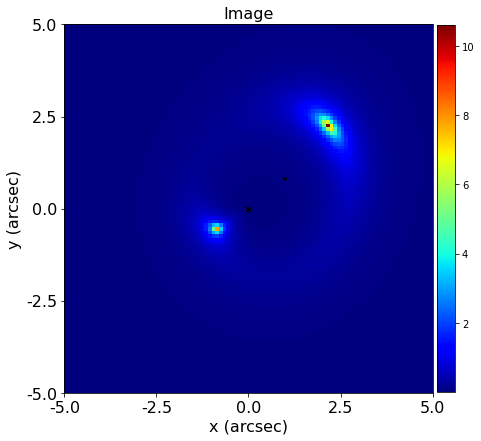

In [10]:
"""Lets look at the tracer's image - this is the image we'll be simulating."""
aplt.Tracer.image(tracer=tracer, grid=grid)

In [11]:
"""
We can now pass this simulator a tracer, which creates the ray-traced image plotted above and simulates it as an
imaging dataset.
"""
imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

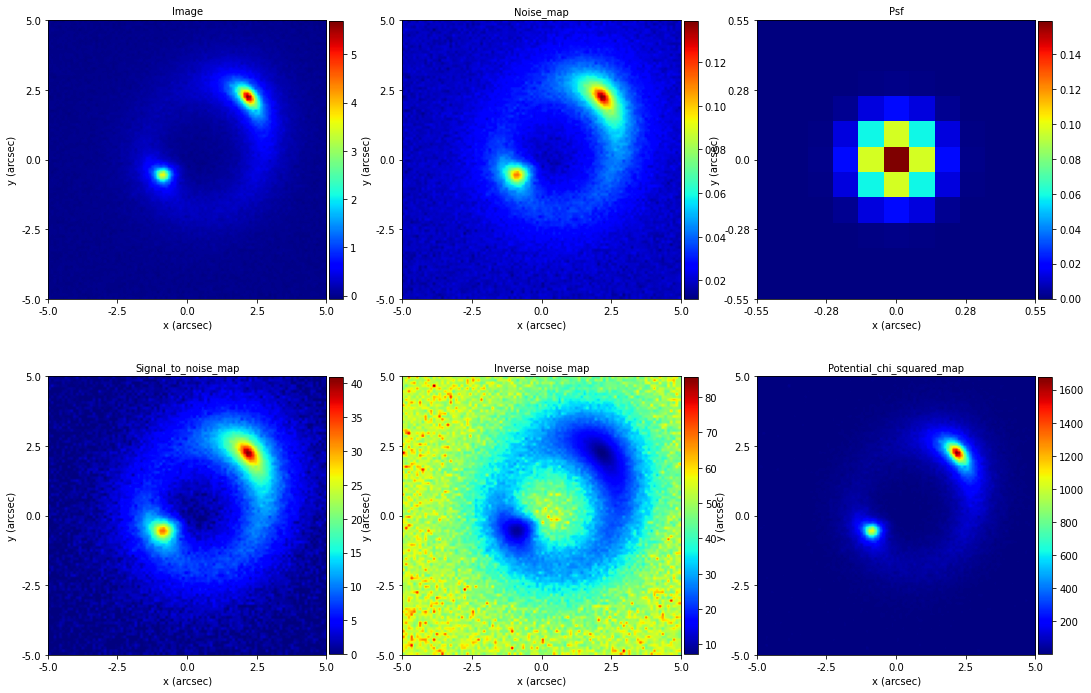

In [12]:
"""Lets plot the simulated imaging dataset before we output it to fits."""
aplt.Imaging.subplot_imaging(imaging=imaging)

In [13]:
"""Output our simulated dataset to the dataset path as .fits files"""
imaging.output_to_fits(
    image_path=f"{data_folder}/image.fits",
    psf_path=f"{data_folder}/psf.fits",
    noise_map_path=f"{data_folder}/noise_map.fits",
    overwrite=True,
)

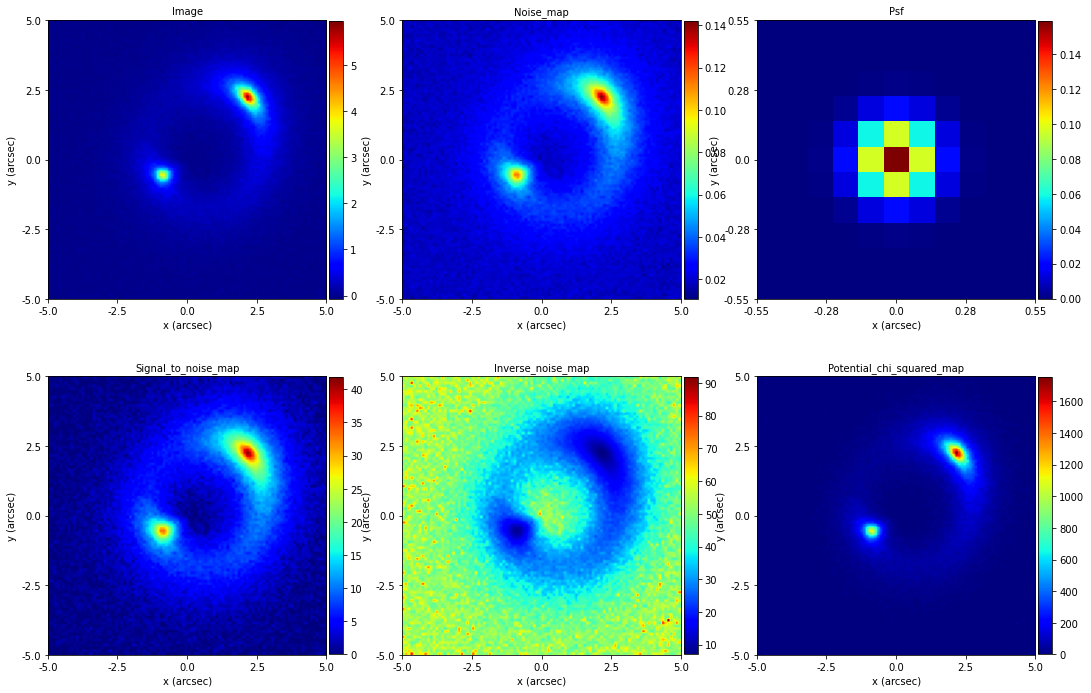

In [38]:
"""Lets plot the simulated imaging dataset before we output it to fits."""
aplt.Imaging.subplot_imaging(imaging=imaging)
